<a id="topC"></a>

# Running the COS Data Pipeline (`CalCOS`)

# Learning Goals
<font size="4 "> This Notebook is designed to walk the user (<em>you</em>) through:</font>

**1. [Setting up the environment to run `CalCOS`](#setupC)**

\- 1.1. [Prerequisites](#prereqC)

\- 1.2. [Create your conda environment](#condaenvC)

\- 1.3. [Imports and basic directories](#impdirC)

\- 1.4. [Set up a reference file directory](#lrefC)


**2. [Gathering the data to run `CalCOS`](#gatherC)**

\- 2.1. [Downloading the raw data](#datadlC)

\- 2.2. [Gathering reference files](#reffileC)

**3. [Processing raw COS data using `CalCOS`](#runC)**

\- 3.1. [Running `CalCOS`: *From a python environment*](#runpyC)

\- 3.2. [Running `CalCOS`: *From the command line*](#runcliC)

**4. [Re-processing COS data with altered parameters](#rerunC)**

\- 4.1. [Altering the calibration switches](#alterswitchC)

\- 4.2. [Running `CalCOS` with a specific set of switches](#switchrunC)

\- 4.3. [Running `CalCOS` with a different reference file](#refrunC)


# 0. Introduction
**The Cosmic Origins Spectrograph ([*COS*](https://www.nasa.gov/content/hubble-space-telescope-cosmic-origins-spectrograph)) is an ultraviolet spectrograph on-board the Hubble Space Telescope ([*HST*](https://www.stsci.edu/hst/about)) with capabilities in the near ultraviolet (*NUV*) and far ultraviolet (*FUV*).**

**`CalCOS`** is the data processing pipeline which converts the raw data produced by COS's detectors onboard HST into usable spectral data. It transforms the data from a list of many individual recorded photon interactions into tables of wavelength and flux at that wavelength.

**This tutorial aims to prepare you run the `CalCOS` pipeline to reduce spectral data taken with the COS instrument.** It focuses on COS data taken in `TIME-TAG` mode. 
*Note* that there is another, less commonly used mode: `ACCUM`, which should generally be used only for UV bright targets.

- For an in-depth manual to working with COS data and a discussion of caveats and user tips, see the [COS Data Handbook](https://hst-docs.stsci.edu/display/COSDHB/).
- For a detailed overview of the COS instrument, see the [COS Instrument Handbook](https://hst-docs.stsci.edu/display/COSIHB/).

#### Notes for those new to Python/Jupyter/Coding:
- You will frequently see exclamation points (**!**) or dollar signs (**\$**) at the beginning of a line of code. These are not part of the actual commands. The exclamation points tell a jupyter Notebook to pass the following line to the command line, and the dollar sign merely indicates the start of a terminal prompt. 

<a id = setupC></a>
# 1. Setting up the environment to run `CalCOS`

The first step to processing your data is setting up an environment from which to run `CalCOS`.
<a id = prereqC></a>
## 1.1. Prerequisites
This tutorial assumes some basic knowledge of the command line and was built using a unix style shell. Those using a Windows computer will likely have the best results if working within the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install-win10).

If you do not already have any distribution of the `conda` tool, see [this page](https://astroconda.readthedocs.io/en/latest/getting_started.html#getting-started-jump) for instructions, and install either [`anaconda` (more beginner friendly, \~ 3 GB, lots of extras you likely won't use)](https://docs.anaconda.com/anaconda/install/) or [`miniconda` (\~ 400 MB, only what you need to make environments)](https://docs.conda.io/en/latest/miniconda.html).



<a id = condaenvC></a>
## 1.2. Create your conda environment

Once you have `conda` installed, you can create an environment. 

Open up your terminal app, likely `Terminal` or `iTerm` on a Mac or `Windows Terminal` or `Powershell` on Windows.

First, add the "conda-forge" channel to your computer's conda channel list. This enables conda to look in the right place to find all the packages we want to install.

``` $ conda config --add channels conda-forge ```

Now we can create a new environment for running `CalCOS`; let's call it `calcos_env`, and initialize it with python version 3.10 and several packages we'll need.

``` $ conda create -n calcos_env python=3.10 notebook jupyterlab numpy astropy matplotlib astroquery```

After allowing conda to proceed to installing the packages (type `y` then hit enter/return), you can see all of your environments with:

``` $ conda env list```

and then switch over to your new environment with 

``` $ conda activate calcos_env ```

<!-- Substitute for working astroconda - hopefully change once astroconda is updated  -->

Finally you must install the `CalCOS` and `CRDS` packages using `pip`:

``` $ pip install calcos crds```

At this point, typing `calcos --version` into the command line and hitting enter should no longer yield the error 

> ```command not found: calcos``` 

but rather respond with a version number, i.e. `3.4.0`.

At this point, if you started this Jupyter Notebook in another Python environment, you should now quit that instance, run `$ conda activate calcos_env`, and reopen this Jupyter Notebook. If you're unsure whether you're already using the `calcos_env` environment, you can see the active environment with the following cell.

In [7]:
# Displays name of current conda environment
# try:
#     from os import environ
#     print("You are using:", environ["CONDA_DEFAULT_ENV"])
# except Exception:
#     # Use another method to display the conda environment name if environment variable 'CONDA_DEFAULT_ENV' isn't set.
#     import subprocess
#     process = subprocess.run('conda info --envs |grep "*"', shell=True, check=True, stdout=subprocess.PIPE, universal_newlines=True)
#     print("Your are using:", process.stdout.split("*")[0].strip())

from os import environ    
if "CONDA_DEFAULT_ENV" in environ:
    print("You are using:", environ["CONDA_DEFAULT_ENV"])
else:
    # Use another method to display the conda environment name if environment variable 'CONDA_DEFAULT_ENV' isn't set.
    import subprocess
    process = subprocess.run('conda info --envs |grep "*"', shell=True, check=True, stdout=subprocess.PIPE, universal_newlines=True)
    print("Your are using:", process.stdout.split("*")[0].strip())

You are using: py_3_8_12_new


<a id=impdirC></a>

## 1.3. Imports and basic directories

We will import the following packages:

- `calcos` to run the COS data pipeline
- `astroquery.mast Mast and Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `numpy` to handle array functions (version $\ge$ 1.17)
- `astropy.io` fits for accessing FITS files
- `astropy.table Table` for creating/reading organized tables of the data
- `matplotlib.pyplot` for plotting data
- `glob`, `shutil`, and `os` for searching and working with system files and variables
- `pathlib Path` for managing system paths

In [2]:
# Import for: The COS Data Reduction Pipeline
import calcos

# Import for: Manipulating arrays
import numpy as np

# Import for: Reading in data
from astropy.io import fits
from astropy.table import Table

# Import for: Plotting
import matplotlib.pyplot as plt
# This line makes matplotlib plots appear in the Notebook instead of possibly showing up in separate windows
%matplotlib inline

# Import for: Downloading data from archive
from astroquery.mast import Observations

# Import for: Searching for files on our system
import glob

# Import for: Making environment variables
import os, shutil

# Import for: Working with system paths
from pathlib import Path

### We will also define a few basic directories in which to place our inputs and outputs.

In [3]:
# These will be important directories for the Notebook

datadir = Path('./data/')
outputdir = Path('./output/')

# Make the directories if they don't exist
datadir.mkdir(exist_ok=True), outputdir.mkdir(exist_ok=True)

(None, None)

<a id = lrefC></a>
## 1.4. Set up a reference file directory

`CalCOS` needs to be able to find all your reference files, (flat field image, bad pixel table, etc.), and the best way to enable that is to create a central directory of all the calibration files you'll need. We refer to this directory  as "lref" by convention, and set a system variable `lref` to the location of the directory. In this section, we will create the `lref` environment variable; however, we need to populate the `lref` folder with the actual reference files. We do this in [Section 2.2](#reffileC). If you have already downloaded the set of COS reference files you need to use into an existing lref directory, you should instead set `lref` to the path to this directory. 

We can assign a system variable in three different ways, depending on whether we are working from:
1. The command line
2. A python environment
3. A Jupyter Notebook

|Unix-style Command Line| Python | Jupyter Notebook|
|-|-|-|
| export lref='./data/reference/...' | os.environ["lref"] = "./data/reference/..."| %env lref ./data/reference/...|


Note that this system variable must be set again with every new instance of a terminal - if you frequently need to use the same `lref` directory, consider adding an export statement to your `.bash_profile` or equivalent file.

Because this is a jupyter Notebook, we set our reference directory with the [cell magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html) below:

<!-- Looking in the headers of our data below, we see that the `$lref` argument appears at the beginning of all of the reference file locations: -->

In [4]:
%env lref ./data/reference/references/hst/cos/

env: lref=./data/reference/references/hst/cos/


We can note the value of the system variable using the `echo` command:

In [5]:
!echo $lref

./data/reference/references/hst/cos/


---

<a id = gatherC></a>
# 2. Gathering the data to run `CalCOS`

The `CalCOS` pipeline can be run either from a python environment, or directly from a Unix-style command line. The two use the same underlying machinery but can differ in syntax. For specifics on the keywords to run `CalCOS` with specific behaviors and arguments, see [Table 3.2: Arguments for Running CalCOS in Python](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration) and [Table 3.3: Command-line Options for Running CalCOS in Unix/Linux/Mac](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration).

<a id = datadlC></a>
## 2.1. Downloading the raw data

First, we need to make sure we have all of our data ready and in the right spot. If you are unfamiliar with searching the archive for data, we recommend that you view our [tutorial on downloading COS data](https://github.com/spacetelescope/COS-Notebooks). This Notebook will largely gloss over downloading the data.

To run `CalCOS`, we will need the following files:
1. All the **raw data** from separate exposures we wish to combine as `_rawtag` fits files
2. The **association** file telling `CalCOS` which files to combine as a `_asn` fits file.

***Note* that we do not generally run the `CalCOS` pipeline directly on the data files, but instead on an association `_asn` file. This allows for the calibration of related exposures into combined `_x1dsum` files.**

If you instead use `_rawtag` or `_corrtag` exposure files files as your inputs, you will only receive the exposure-specific `_x1d` files as your outputs.

For this example, we're choosing the dataset `LCXV13040` of COS/FUV observing the [quasar 3C48](https://en.wikipedia.org/wiki/3C_48). In the cell below we download the data from the archive.

In [6]:
# Guery the MAST archive for data with observation id starting with lcxv1304
q1 = Observations.query_criteria(obs_id='lcxv1304*')

# Make a list of all products we could download associates with this file
pl = Observations.get_product_list(q1)

# Filter to a list of only the products which are association files
asn_file_list = pl[pl["productSubGroupDescription"] == 'ASN']

# Filter to a list of only the products which are rawtag files
rawtag_list = pl[
    (pl["productSubGroupDescription"] == 'RAWTAG_A') | 
    (pl["productSubGroupDescription"] == 'RAWTAG_B')
]

# Download the two file lists to the data directory
rawtag_locs = Observations.download_products(
    rawtag_list, download_dir=str(datadir))
asn_locs = Observations.download_products(
    asn_file_list, download_dir=str(datadir))

**By default, each exposure's files are downloaded to separate directories, as is the association file.**

We need to move around these files to all be in the same directory, which we do below.

In [7]:
# move the files to the base data directory
for lpath in rawtag_locs['Local Path']:
    Path(lpath).replace(datadir/os.path.basename(lpath))
for lpath in asn_locs['Local Path']:
    Path(lpath).replace(datadir/os.path.basename(lpath))
    asn_name = os.path.basename(lpath)

# Delete the now-empty nested subdirectories
shutil.rmtree(datadir/'mastDownload')

<a id = reffileC></a>
## 2.2. Gathering reference files

The following process of gathering reference files is given a detailed explanation in Section 3 of our [Notebook on Setting up an environment to work with COS data](https://github.com/spacetelescope/notebooks/blob/master/notebooks/COS/Setup/Setup.ipynb). Your process will be somewhat simpler and quicker if you have already downloaded the reference files.

Each data file has an associated set of calibration files which are needed to run the associated correction with (i.e. you need the `FLATFILE` to flat field correct the data.) These reference files must be located in the `$lref` directory to run the pipeline.

The Space Telescope Science Institute (STScI) team is regularly producing new calibration files in an effort to keep improving data reduction. Periodically the pipeline is re-run on all COS data.
To determine which reference files were used most recently by STScI to calibrate your data, you can refer to your data file's "CRDS_CTX" keyword in its fits header (see next cell).

In [8]:
# Find all of the raw files:
rawfiles = glob.glob(str(datadir/'*raw*.fits'))
# Get the header of the 0th raw file, look for its CRDS context keyword:
crds_ctx = fits.getheader(rawfiles[0])['CRDS_CTX']
# Print it:
print(f"The CRDS Context last run with {rawfiles[0]} was:\t{crds_ctx}")

The CRDS Context last run with data/lcxv13ezq_rawtag_a.fits was:	hst_1063.pmap


The value of this keyword in the header is a `.pmap` or observatory context file which tells the CRDS calibration data distribution program which files to distribute. You can also find the newest "operational" context on the [HST CRDS website](https://hst-crds.stsci.edu).

To download the reference files specified by a context file, we use the `crds` tool we installed earlier. 

---
**If you haven't already downloaded up-to-date reference files,** (as in Section 3 of "Setup.ipynb",) [click to skip this cell and begin downloading the files!](#skipcellC)

**If you have recently downloaded COS reference files,** (i.e. if you ran Section 3 of the "Setup" Notebook,) you likely do not have to download more reference files. Instead, follow the instructions in this cell and then skip to Section 3.

If you already downloaded the files, you can simply point the pipeline to the ones you downloaded, using the `crds bestrefs` command, as shown in the following three steps. Run these steps from your command line if you already have the reference files in a local cache. *Note* also that there may be newer reference files available. To make sure you are always using the most up-to-date reference files, we advise you familiarize yourself with the newest files and documentation at the [CRDS homepage](https://hst-crds.stsci.edu).

1. The following sets the environment variable for crds to look for the reference data online:

```$ export CRDS_SERVER_URL=https://hst-crds.stsci.edu``` 

2. The following tells crds where to save the files it downloads - set this to the directory where you saved the crds_cache, i.e. in [Section 3 of our Notebook on "Setup"](https://spacetelescope.github.io/COS-Notebooks/Setup.html#crdsS):

```$ export CRDS_PATH=${HOME}/crds_cache```

3. The following will update the data files you downloaded so that they will be processed with the reference files you previously downloaded:

```$ crds bestrefs --files data/*raw*.fits --update-bestrefs --new-context '<the imap or pmap file you used to download the reference files>'```


**Assuming everything ran successfully, you can now [skip to Section 3](#runC).**

---

<a id=skipcellC></a>

<font size="4 "> If you have not yet downloaded the reference files, you will need to do so, as shown below:</font>

<font size="4 ">Caution!</font>
    
<img src= ./figures/warning.png width ="60" title="CAUTION!"> 

*Note* that as of the time of this Notebook's last update, the pipeline context used below was **`hst_0989.pmap`**, but this changes over time. You are running this in the future, and there is certainly a newer context you would be better off working with. Take a minute to consider this, and check the [HST Calibration Reference Data System webpage](http://hst-crds.stsci.edu/) to determine what the **current operational pmap file** is. 

Unless we are connected to the STScI network, or already have the reference files on our machine, we will need to download the reference files and tell the pipeline where to look for the flat files, bad-pixel files, etc.

The process in the following two cells can take a long time and strain network resources. If you have already downloaded *up-to-date* COS reference files, we recommend that you avoid doing so again. Instead, keep these crds files in an accessible location, and point an environment variable `lref` to this directory. For instance, if your `lref` files are on your username's home directory in a subdirectory called `crds_cache`, give Jupyter the following command then skip to [Section 2.3](#runpyC):

```%env lref /Users/<your username>/crds_cache/references/hst/cos/```

If you have an older cache of reference files, you may also simply update your cached reference files. Please see the [CRDS Guide](https://hst-crds.stsci.edu/static/users_guide/index.html) for more information.

Assuming you have not yet downloaded these files, in the next two cells, we will setup an environment of reference files, download the files, and save the output of the crds download process in a log file:

In [9]:
%%capture cap --no-stderr 
# The above ^ allows us to redirect the cell's output into a txt file created in the next cell
#  This avoids a very long printed output
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
# The above ^ sets an environment variable for crds to look for the reference data online
%env CRDS_PATH ./data/reference/ 
#The above ^ tells crds where to save the files it downloads

# The next command depends on your context and pmap file  - it looks up the specified pmap "context" file,
    # which tells it what reference files to download. It then downloads these to the CRDS_PATH directory
# You may wish to update this pmap if there is a newer pmap file - check https://hst-crds.stsci.edu
!crds bestrefs --files data/*raw*.fits  --sync-references=2 --update-bestrefs --new-context 'hst_0989.pmap' 

In [10]:
# This file will contain the output of the last cell
with open(str(outputdir/'crds_output_1.txt'), 'w') as f:
    f.write(cap.stdout)

**We'll print the beginning and end of that file just to take a look:**

In [11]:
crds_output_dict = {}  # pair each line with its line number, start at 0
with open(str(outputdir/'crds_output_1.txt'), 'r') as cell_outputs:  # open the file
    for linenum, line in enumerate(cell_outputs):  # loop through lines
        crds_output_dict[linenum] = line[:-1]  # save each line to dict
# Get the length of the dictionary - how many lines of output
total_lines = len(crds_output_dict)

print(
    f"Printing the first and last 5 lines of {total_lines} lines output by the previous cell:\n")
for i in np.append(range(5), np.subtract(total_lines - 1, range(5)[::-1])):
    print(f"Line {i}:   \t", crds_output_dict[i])

# Delete the contents of the dict to avoid 'garbage' filling memory
crds_output_dict.clear()

Printing the first and last 5 lines of 14 lines output by the previous cell:

Line 0:   	 env: CRDS_SERVER_URL=https://hst-crds.stsci.edu
Line 1:   	 env: CRDS_PATH=./data/reference/
Line 2:   	 CRDS - INFO -  No comparison context or source comparison requested.
Line 3:   	 CRDS - INFO -  ===> Processing data/lcxv13ezq_rawtag_a.fits
Line 4:   	 CRDS - INFO -  ===> Processing data/lcxv13ezq_rawtag_b.fits
Line 9:   	 CRDS - INFO -  ===> Processing data/lcxv13ffq_rawtag_a.fits
Line 10:   	 CRDS - INFO -  ===> Processing data/lcxv13ffq_rawtag_b.fits
Line 11:   	 CRDS - INFO -  0 errors
Line 12:   	 CRDS - INFO -  0 warnings
Line 13:   	 CRDS - INFO -  9 infos


**Line 158 of the output should show 0 errors.**

If you receive errors, you may need to attempt to run the `crds bestrefs` line again. These errors can arise from imperfect network connections. 

**It is recommended that you use this new `$lref` folder of reference files for subsequent `CalCOS` use, rather than re-downloading the reference files each time.** To do this (*after completing this Notebook*): 
- Save this folder somewhere accessibile, i.e. `~/crds_cache`
- Add a line to your .bashrc or similar: `export lref=<Path to your reference file directory>`
  - If you wish to avoid adding this to your .bashrc, simply type the line above into any terminal you wish to run `CalCOS` from
  - If running `CalCOS` from a jupyter Notebook, instead add a cell with: `%env lref /Users/<Your Username>/crds_cache/references/hst/cos`

<a id = runC></a>
# 3. Processing raw COS data using `CalCOS`

**Now we have all the reference files we need to  run the pipeline on our data.**

This following cells which run the pipeline can take a while, sometimes more than **10 minutes**, so you may choose to not run the remaining cells of this Notebook on the example data. You may, instead, wish to simply look at the rendered output in the [html version of this Notebook](https://spacetelescope.github.io/COS-Notebooks/Calcos.html).

By default, the pipeline also outputs hundreds of lines of text - we will suppress the printing of this text and instead save it to a text file.

<a id = runpyC></a>
## 3.1. Running `CalCOS`: *From a python environment*

**Now, we can run the pipeline program:**

Note that generally, `CalCOS` should be run on an association (`_asn`) file (in this case: `./data/lcxv13040_asn.fits`). You *may* run `CalCOS` directly on `_rawtag` or `_corrtag` exposure files, but this will not produce an `_x1dsum` file and can result in errors for data taken at certain lifetime positions. No matter what type of files you run `CalCOS` on, you should only specify the FUVA segment's file, i.e. the `_rawtag_a` file. If a `rawtag_b` file is in the same directory, `CalCOS` will find both segments' files.

In this example, we also specify that `verbosity` = 2, resulting in a **very** verbose output, and we specify a directory to put all the output files in: `output/calcos_processed_1`. To avoid polluting this Notebook with more than a thousand lines of the output, we again capture the output of the next cell and save it to `output/output_calcos_1.txt` in the cell below.

In [12]:
%%capture cap --no-stderr 
# Above ^ again, capture the output and save it in the next cell

calcos.calcos(str(datadir/asn_name), # 1st param specifies which asn file to run the pipeline on
              verbosity=2, # verbosity param: [0 = don't print much at all to the console or text file, 1 = print some, 2 = print everything]
              outdir=str(outputdir/"calcos_processed_1")) # save all resulting files in this subdirectory in our output directory

RuntimeError: output files already exist

In [13]:
# This file now contains the output of the last cell
with open(str(outputdir/'output_calcos_1.txt'), 'w') as f:
    f.write(cap.stdout)

**Again, we'll print the beginning and end of that file just to take a look and make sure `CalCOS` ran successfully.**

In [14]:
calcos_output_dict = {}  # pair each line with its line number, start at 0
with open(str(outputdir/'output_calcos_1.txt'), 'r') as cell_outputs:  # open the file
    for linenum, line in enumerate(cell_outputs):  # loop through lines
        calcos_output_dict[linenum] = line[:-1]  # save each line to dict
# Get the length of the dictionary - how many lines of output
total_lines = len(calcos_output_dict)

print(
    f"Printing the first and last 5 lines of {total_lines} lines output by the previous cell:\n")
for i in np.append(range(5), np.subtract(total_lines - 1, range(5)[::-1])):
    print(f"Line {i}:   \t", calcos_output_dict[i])

calcos_output_dict.clear()  # Delete the contents of the dict

Printing the first and last 5 lines of 46 lines output by the previous cell:

Line 0:   	 CALCOS version 3.4.4
Line 1:   	 numpy version 1.23.4
Line 2:   	 astropy version 5.2.1
Line 3:   	 Begin 03-Mar-2023 11:58:26 EST
Line 4:   	 Association file = data/lcxv13040_asn.fits
Line 41:   	 ERROR:    output/calcos_processed_1/lcxv13040_x1dsum.fits
Line 42:   	 ERROR:    output/calcos_processed_1/lcxv13040_x1dsum1.fits
Line 43:   	 ERROR:    output/calcos_processed_1/lcxv13040_x1dsum2.fits
Line 44:   	 ERROR:    output/calcos_processed_1/lcxv13040_x1dsum3.fits
Line 45:   	 ERROR:    output/calcos_processed_1/lcxv13040_x1dsum4.fits


<a id = runcliC></a>

## 3.2. Running `CalCOS`: *From the command line*

The syntax for running `CalCOS` from the command line is very similar. Assuming your data files, `lref` directory, and reference files are all where you've told `CalCOS` to look, you can simply run:

```calcos --outdir directory_to_save_outputs_in filename_asn.fits```

*or, if you want to save a very verbose output to a log file `log.txt`*:

```calcos -v --outdir directory_to_save_outputs_in filename_asn.fits > log.txt```

To see the full list of commands, [Table 3.2:Command-line Options for Running CalCOS in Unix/Linux/Mac](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-6-customizing-cos-data-calibration), or run the following cell with no arguments.

In [15]:
!calcos

The command-line options are:
  --version (print the version number and exit)
  -r (print the full version string and exit)
  -q (quiet)
  -v (very verbose)
  -s (save temporary files)
  -o outdir (output directory name)
  --find yes (find Y location of spectrum)
  --find no (use Y location of spectrum from 1dx file and wavecal)
  --find cutoff (find Y location if sigma <= cutoff)
  --csum (create 'calcos sum' image)
  --only_csum (do little else but create csum)
  --raw (use raw coordinates for csum image)
  --compress parameters (compress csum image)
  --binx X_bin_factor (csum bin factor in X)
  --biny Y_bin_factor (csum bin factor in Y)
  --shift filename (file to specify shift values)
  --stim filename (append stim locations to filename)
  --live filename (append livetime factors to filename)
  --burst filename (append burst info to filename)

Following the options, list one or more association
files (rootname_asn) or raw files (rootname_raw).
ERROR:  An association file name or o

<a id = rerunC></a>
# 4. Re-processing COS data with altered parameters

<a id = alterswitchC></a>
## 4.1. Altering the calibration switches

The way to alter how `CalCOS` runs - i.e. which calibrations it performs - is with the **calibration switches** contained in the fits headers. 

The switches (with the exception of "XTRACTALG"), can be set to the values in the following table:

|***Value:***|"PERFORM"|"OMIT"|"N/A"|
|-|-|-|-|
|***Meaning:***|Performs the calibration step|Does not perform the calibration step|This step would not make sense for this file|

`XTRACTALG` instead can be set to either "BOXCAR" or "TWOZONE", to specify the spectral extraction algorithm to be used. For more information, see [Section 3.2.1: "Overview of TWOZONE extraction" of the Data Handbook](https://hst-docs.stsci.edu/cosdhb/chapter-3-cos-calibration/3-2-pipeline-processing-overview#id-3.2PipelineProcessingOverview-3.2.1OverviewofTWOZONEextraction).

In the cell below, we get a full list of the switches by name. If you want to learn more about the calibration steps and switches, see [Chapters 2 and 3 of the COS Data Handbook](https://hst-docs.stsci.edu/cosdhb).

In [16]:
# Reads the header of the 0th rawfile
header = fits.getheader(rawfiles[0])
# The calib switches are found in lines 82 - 109 of the header
calibswitches = header[82:109]
calibswitches

TAGFLASH= 'AUTO            '   / Type of flashed exposures in time-tag          
                                                                                
              / CALIBRATION SWITCHES: PERFORM, OMIT, COMPLETE                   
                                                                                
FLATCORR= 'PERFORM '           / apply flat-field correction                    
DEADCORR= 'PERFORM '           / correct for deadtime                           
DQICORR = 'PERFORM '           / data quality initialization                    
STATFLAG=                    T / Calculate statistics?                          
TEMPCORR= 'PERFORM '           / correct for thermal distortion                 
GEOCORR = 'PERFORM '           / correct FUV for geometic distortion            
DGEOCORR= 'OMIT    '           / Delta Corrections to FUV Geometric Distortion  
IGEOCORR= 'PERFORM '           / interpolate geometric distortion in INL file   
RANDCORR= 'PERFORM '        

**Let's begin by switching off all the switches currently set to "PERFORM" to a new value of "OMIT", in every rawfile:**

In [17]:
verbose = False  # Set to True to see a bit more about what is going on here

# Find each rawfile, i is just a counter variable for the files you loop through
for i, rawfile in enumerate(rawfiles):
    if verbose:
        print(rawfile)
    header = fits.getheader(rawfiles[i])  # Read that rawfiles header
    # Find all calib switches
    corrections = [key for key in list(header.keys()) if "CORR" in key]

    for correction in corrections:
        if header[correction] == 'PERFORM':
            if verbose:
                print("switching\t", header[correction],
                      "\t", correction, "\tto OMIT")
            # Turn off all the calib switches
            fits.setval(rawfile, correction, value='OMIT', ext=0)

**In this case, `CalCOS` realizes that all the switches are set to "OMIT", and exits without doing anything.**

In [18]:
calcos.calcos(str(datadir/asn_name), verbosity=0,
              outdir=str(outputdir/"calcos_processed_2"))
# Run CalCOS with all calib switches OFF; allow text output this time

CALCOS version 3.4.4
numpy version 1.23.4
astropy version 5.2.1
Begin 03-Mar-2023 11:58:28 EST
Nothing to do; all calibration switches are OMIT.


0

<a id = switchrunC></a>
## 4.2. Running `CalCOS` with a specific set of switches
Now, let's set a single switch to "PERFORM", and just run a flat-field correction ("FLATCORR") and a pulse-height filter correction ("PHACORR"). Set verbosity = 1 or 2 to learn more about how `CalCOS` is working.

In [19]:
verbose = False

# Find each rawfile, i is just a counter variable for the files you loop through
for i, rawfile in enumerate(rawfiles):
    if verbose:
        print(rawfile)
    # Change the header's keyword FLATCORR to the value PERFORM
    fits.setval(rawfile, "FLATCORR", value='PERFORM', ext=0)
    # Change the header's keyword PHACORR to the value PERFORM
    fits.setval(rawfile, "PHACORR", value='PERFORM', ext=0)

In [20]:
%%capture cap --no-stderr
calcos.calcos(
    str(datadir/asn_name),
    verbosity=2,
    outdir=str(outputdir/"calcos_processed_3")
)

RuntimeError: output files already exist

In [21]:
# This file now contains the output of the last cell
with open(str(outputdir/'output_calcos_3.txt'), 'w') as f:
    f.write(cap.stdout)

<a id = refrunC></a>
## 4.3. Running `CalCOS` with a different reference file

You may wish to run `CalCOS` with a specific flat file, bad pixel table, or any other reference file. `CalCOS` offers the ability to do just this on a file-by-file basis, by changing the CALIBRATION REFERENCE FILES values in the header of your data.

As an example, we check which calibration files are selected for one of our rawtag files.

In [22]:
header = fits.getheader(rawfiles[0])  # Read 0th rawfile's header
# The 110th to 138th lines of the header are filled with these reference files
refFiles = header[110:138]
# Get just the keywords i.e. "FLATFILE" and "DEADTAB"
refFile_keys = list(refFiles[2:].keys())
refFiles

TDSCORR = 'OMIT    '           / switch for time-dependent sensitivity correctio
                                                                                
              / CALIBRATION REFERENCE FILES                                     
                                                                                
FLATFILE= 'lref$z6n16118l_flat.fits' / Pixel to Pixel Flat Field Reference File 
DEADTAB = 'lref$s7g1700gl_dead.fits' / Deadtime Reference Table                 
BPIXTAB = 'lref$5b91920bl_bpix.fits' / bad pixel table                          
SPOTTAB = 'lref$5b91820fl_spot.fits' / Transient Bad Pixel Table                
GSAGTAB = 'lref$5b919208l_gsag.fits' / Gain Sagged Region Reference File        
HVTAB   = 'N/A                    ' / High voltage command level Reference Table
BRFTAB  = 'lref$x1u1459il_brf.fits' / Baseline Reference Frame Reference Table  
GEOFILE = 'lref$x1u1459gl_geo.fits' / Geometric Correction Reference File       
DGEOFILE= 'N/A              

For this section, let's download another Pulse Height Amplitude (\_pha) table file using the `crds` tool (*I arbitrarily choose this one*):

In [23]:
!crds sync --files u1t1616ll_pha.fits --output-dir $lref

CRDS - INFO -  Symbolic context 'hst-operational' resolves to 'hst_1067.pmap'
CRDS - INFO -  Reorganizing 28 references from 'flat' to 'flat'
CRDS - INFO -  Syncing explicitly listed files.
CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  3 infos


Now we can use the fits headers to set this new file as the `_pha` file. As a demonstration, let's do this for **only the raw data from segment FUVA** of the FUV detector:

*Note* that we are still only performing two corrections, as all calibration switches aside from `FLATCORR` and `PHACORR` are set to `OMIT`.

In [24]:
# Find just the FUVA raw files
rawfiles_segA = glob.glob(str(datadir/'*rawtag_a*.fits'))
for rawfileA in rawfiles_segA:
    print(rawfileA)
    with fits.open(rawfileA, mode='update') as hdulist:
        hdr0 = hdulist[0].header  # Update the 0th header of that FUVA file
        # NOTE that you need the $lref in there if you put it with your other ref files
        hdr0["PHATAB"] = 'lref$u1t1616ll_pha.fits'

data/lcxv13ezq_rawtag_a.fits
data/lcxv13ffq_rawtag_a.fits
data/lcxv13faq_rawtag_a.fits
data/lcxv13f4q_rawtag_a.fits


**Finally, let's run `CalCOS` with the new `_pha` file for only the FUVA data:**

In [25]:
%%capture cap --no-stderr
calcos.calcos(str(datadir/asn_name), verbosity=2, outdir=str(outputdir/"calcos_processed_4"))

RuntimeError: output files already exist

In [26]:
# This file now contains the output of the last cell
with open(str(outputdir/'output_calcos_4.txt'), 'w') as f:
    f.write(cap.stdout)

<font size="5">Before we go, let's have a look at the spectra we calibrated and extracted in <a href="#runpyC">Section 2.3</a></font>

**We'll make a very quick plot to show the two spectra calibrated by STScI's pipeline and by us right now.**
The two should agree very well. Small differences may be expected, given that the `RANDSEED` values may be different between the two versions.

Much more information on reading in and plotting COS spectra can be found in our other tutorial: [Viewing COS Data](https://spacetelescope.github.io/COS-Notebooks/ViewData.html).

*(You can ignore the UnitsWarning below)*

INFO: Found cached file data/compare/mastDownload/HST/lcxv13040/lcxv13040_asn.fits with expected size 11520. [astroquery.query]
INFO: Found cached file data/compare/mastDownload/HST/lcxv13040/lcxv13040_x1dsum.fits with expected size 1811520. [astroquery.query]


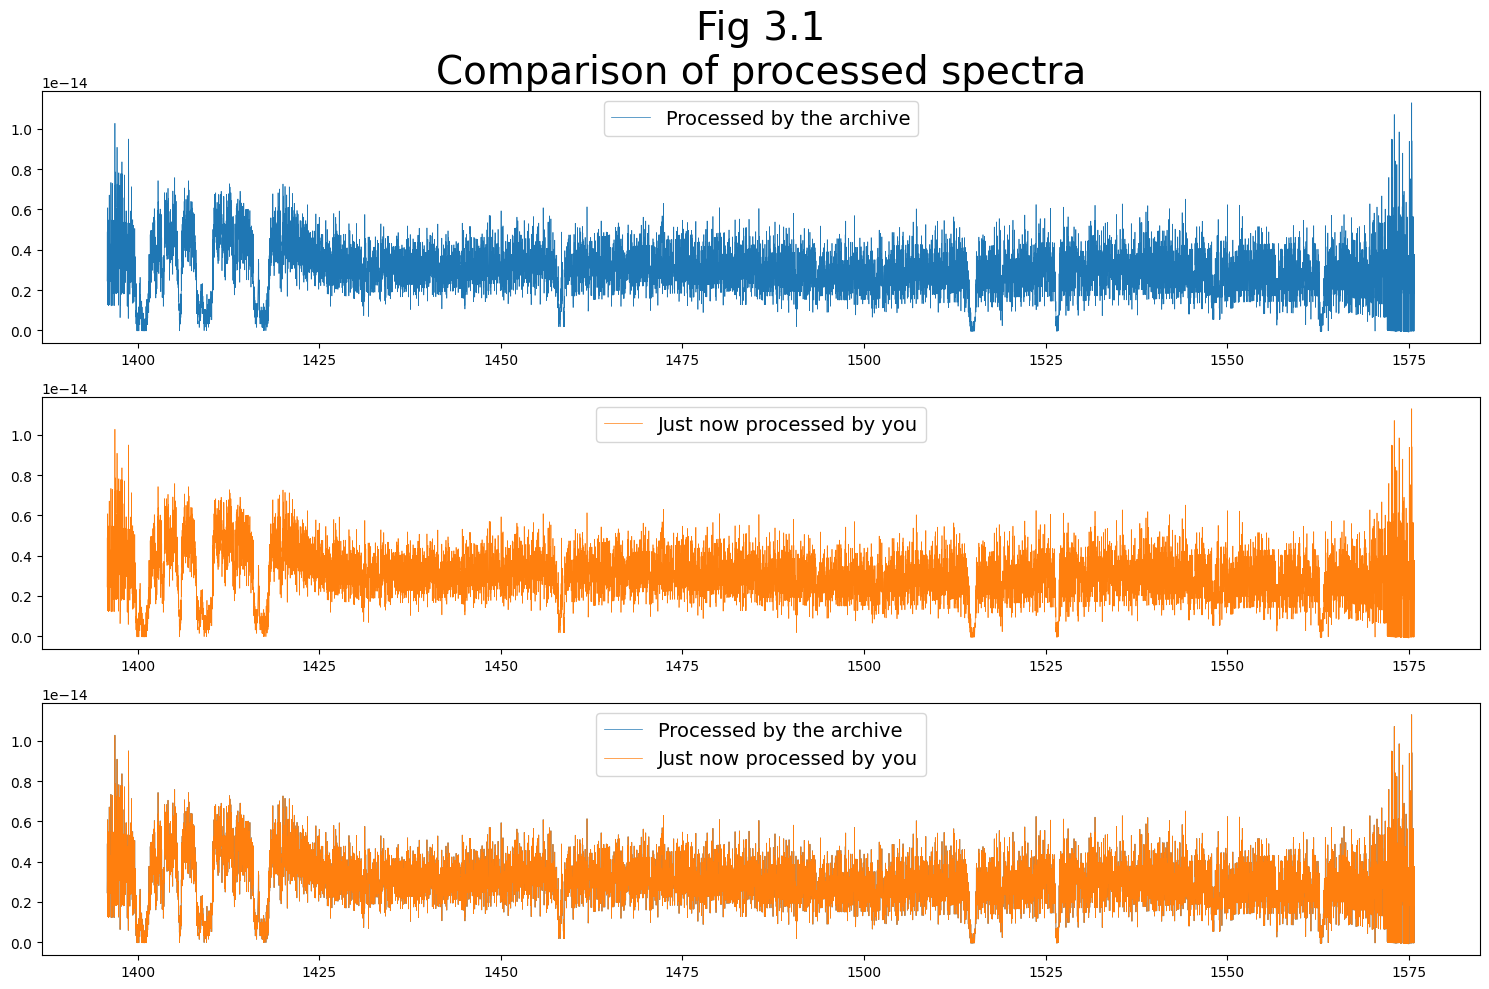

In [27]:
# Get the STScI calibrated x1dsum spectrum from the archive
Observations.download_products(Observations.get_product_list(Observations.query_criteria(obs_id='lcxv13040')),
                               mrp_only=True,  download_dir='data/compare/')
# Read in this STScI spectrum
output_spectrum = Table.read(
    str(datadir/'compare/mastDownload/HST/lcxv13040/lcxv13040_x1dsum.fits'))
wvln_orig, flux_orig, fluxErr_orig, dqwgt_orig = output_spectrum[1][
    "WAVELENGTH", "FLUX", "ERROR", "DQ_WGT"]
# Convert the data quality (DQ) weight into a boolean we can use to mask the data
dqwgt_orig = np.asarray(dqwgt_orig, dtype=bool)

# Also read in the spectrum we recently calibrated in Section 2.3
output_spectrum = Table.read(
    str(outputdir/'calcos_processed_1/lcxv13040_x1dsum.fits'))
new_wvln, new_flux, new_fluxErr, new_dqwgt = output_spectrum[1][
    "WAVELENGTH", "FLUX", "ERROR", "DQ_WGT"]
# Convert the data quality (DQ) weight into a boolean we can use to mask the data
new_dqwgt = np.asarray(new_dqwgt, dtype=bool)

fig, (ax0, ax1, ax2) = plt.subplots(
    3, 1, figsize=(15, 10))  # Build a 3 row x 1 column figure
ax0.plot(wvln_orig[dqwgt_orig], flux_orig[dqwgt_orig], linewidth=0.5, c='C0',
         label="Processed by the archive")  # Plot the archive's spectrum in top section
ax1.plot(new_wvln[new_dqwgt], new_flux[new_dqwgt], linewidth=0.5, c='C1',
         label="Just now processed by you")  # Plot your calibrated spectrum in middle section

ax2.plot(wvln_orig[dqwgt_orig], flux_orig[dqwgt_orig], linewidth=0.5, c='C0',
         label="Processed by the archive")  # Plot both spectra in bottom section
ax2.plot(new_wvln[new_dqwgt], new_flux[new_dqwgt],
         linewidth=0.5, c='C1', label="Just now processed by you")

ax0.legend(loc='upper center', fontsize=14)
ax1.legend(loc='upper center', fontsize=14)
ax2.legend(loc='upper center', fontsize=14)
ax0.set_title("Fig 3.1\nComparison of processed spectra", size=28)
plt.tight_layout()
plt.savefig(str(outputdir/"fig3.1_compare_plot.png"), dpi=300)

## Congratulations! You finished this Notebook!
### There are more COS data walkthrough Notebooks on different topics. You can find them [here](https://spacetelescope.github.io/COS-Notebooks/).


---
## About this Notebook
**Author:** Nat Kerman - <nkerman@stsci.edu>

**Updated On:** 2022-03-24


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*

## Citations

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#topC)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 

<br></br>
<br></br>
<br></br>